In [2]:
import numpy as np
import cv2 as cv
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
square_size = 24.5 # mm
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) * square_size

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_calibration/calibration_images/*.jpg')


In [54]:
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (9,6), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
cv.destroyAllWindows()

In [55]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [56]:
np.set_printoptions(suppress=True, precision=4)

print(mtx)

[[2330.4972    0.     1503.0136]
 [   0.     2334.0017 2163.4301]
 [   0.        0.        1.    ]]


In [57]:
print(dist)

[[-0.3587  0.1388 -0.0046  0.0003 -0.0266]]


In [3]:
# Load the CSV file
extrinsic_points_df = pd.read_csv('/Users/ryan/Documents/image_processing/extrinsic_points_mat.csv')

In [4]:
# Extract object points (convert from feet to meters if needed)
object_points = extrinsic_points_df[['easting', 'northing', 'elev']].values

# Extract image points
image_points = extrinsic_points_df[['u', 'v']].values

In [60]:
# Convert to float32 for OpenCV
object_points = np.array(object_points, dtype=np.float32)
image_points = np.array(image_points, dtype=np.float32)

In [63]:
tvec_guess = np.array([[712159.5978], [33136.97614], [3.81254]], dtype=np.float64)
rvec_guess = np.array([[1.5708], [1.5708], [0]], dtype=np.float64)

In [64]:
# Using solvePnP with the iterative method
success, rvec, tvec = cv.solvePnP(object_points, image_points, mtx, dist,
                                  rvec_guess, tvec_guess, useExtrinsicGuess=True, flags=cv.SOLVEPNP_ITERATIVE)

# Optional: Convert rotation vector to rotation matrix
rotation_matrix, _ = cv.Rodrigues(rvec)

In [65]:
print("Rotation Matrix:")
print(rotation_matrix)

print("Translation Vector:")
print(tvec)

Rotation Matrix:
[[ 0.4831  0.7242  0.4922]
 [ 0.3782  0.3344 -0.8632]
 [-0.7897  0.6032 -0.1123]]
Translation Vector:
[[ 814633.6054]
 [-488536.4304]
 [ -47877.5461]]


In [66]:
def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])  # Roll
        y = np.arctan2(-R[2, 0], sy)       # Tilt (Pitch)
        z = np.arctan2(R[1, 0], R[0, 0])   # Azimuth (Yaw)
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])

euler_angles = rotation_matrix_to_euler_angles(rotation_matrix)


In [67]:
# Convert radians to degrees for easier interpretation
azimuth = np.degrees(euler_angles[2])
tilt = np.degrees(euler_angles[1])
roll = np.degrees(euler_angles[0])

# Print the angles
print(f"Azimuth (Yaw): {azimuth}")
print(f"Tilt (Pitch): {tilt}")
print(f"Roll: {roll}")

Azimuth (Yaw): 38.05677849795758
Tilt (Pitch): 52.15467365355506
Roll: 100.55154486571327


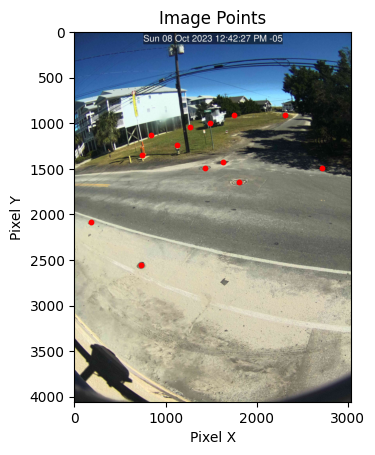

In [5]:
# Load an example image (provide the path to your image)
image_path = 'CAM_CB_03_20231008174225.jpg'  # Replace with your image path
image = cv.imread(image_path)

# Convert image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Plot points on the image
plt.imshow(image_rgb)
plt.scatter(image_points[:, 0], image_points[:, 1], c='red', s=10, marker='o')
plt.title('Image Points')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# Save or show the image
plt.savefig('annotated_image.png',  dpi=300)  # Save the image with annotations
plt.show()  # Display the image with annotations


In [17]:
# Undistort the image
undistorted_image = cv.undistort(image, mtx, dist)

Text(0, 0.5, 'Pixel Y')

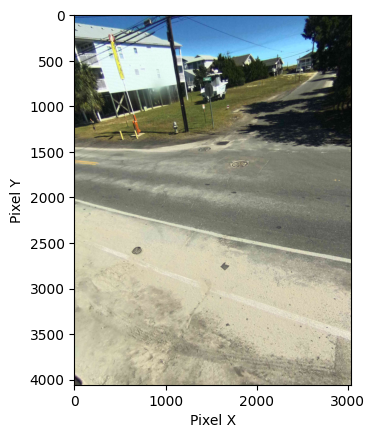

In [18]:
# Convert image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv.cvtColor(undistorted_image, cv.COLOR_BGR2RGB)

# Plot points on the image
plt.imshow(image_rgb)
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

In [75]:
# Compute the rectification transform
rectification_transform = cv.stereoRectify(mtx, dist, mtx, dist, image.shape[:2], rotation_matrix, tvec)[0]

In [76]:
# Calculate the rectification map
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, rectification_transform, mtx, image.shape[:2], cv.CV_32FC1)

# Apply the rectification
rectified_image = cv.remap(undistorted_image, mapx, mapy, cv.INTER_LINEAR)


Text(0, 0.5, 'Pixel Y')

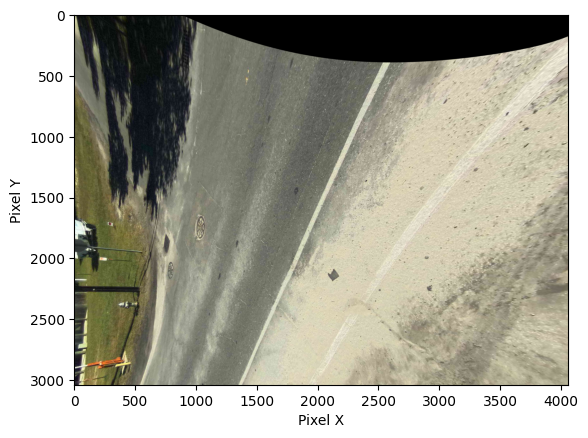

In [77]:
# Convert image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv.cvtColor(rectified_image, cv.COLOR_BGR2RGB)

# Plot points on the image
plt.imshow(image_rgb)
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

In [78]:
new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, image.shape[:2], alpha=1, centerPrincipalPoint=True)

In [79]:
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, rectification_transform, new_camera_mtx, image.shape[:2], cv.CV_32FC1)

In [84]:
rectified_image = cv.remap(undistorted_image, mapx, mapy, cv.INTER_LINEAR)

In [82]:
x, y, w, h = roi
rectified_image = rectified_image[y:y+h, x:x+w]

Text(0, 0.5, 'Pixel Y')

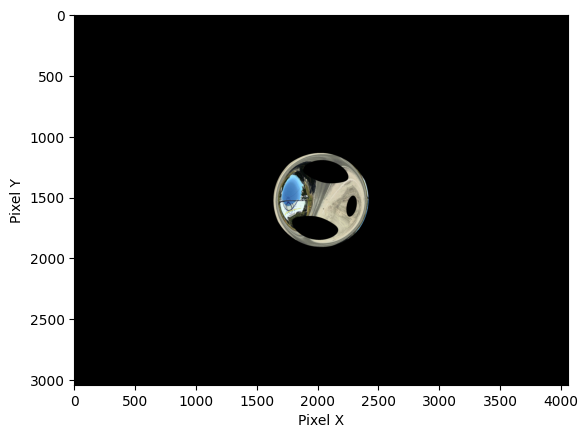

In [85]:
# Convert image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv.cvtColor(rectified_image, cv.COLOR_BGR2RGB)

# Plot points on the image
plt.imshow(image_rgb)
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# mergeRectify

In [38]:
import sys

# Add the directory to sys.path
sys.path.append('coastalimagelib/src/coastalimagelib')

from supportfunctions import *
from corefunctions import *

In [39]:
grid = pd.read_csv('lidar/grid_data.csv', index_col=0)

In [69]:
max(grid.values)

TypeError: 'method' object is not iterable

In [41]:
# Location of our calibration data, stored in a .yaml file inside this repository
calibration_loc = ('camera_calibration/cameraData.yml')

cams = ['CB_03']

# Call a support function to format .yaml files into CIRN convention
m, ex = loadYamlDLT(calibration_loc,cams) 

In [42]:
m

array([list([3040, 4056, 1503.0136, 2163.4301, 2330.4972, 2334.0017, -0.358733094, 0.138783902, -0.0266492608, -0.00460744699, 0.000325655704])],
      dtype=object)

In [43]:
cameras = np.empty(len(cams),dtype=object)
for i in range(len(cams)):
    cameras[i] = CameraData(m[i], ex[i], coords = 'local', origin= 'None', mType = 'DLT', nc=3)

In [44]:
# Grid boundaries

# xCent = float(grid.columns.values.min())
# xMax = float(grid.columns.values.max()) * 2
# xDiff = (xMax - xCent)
# xMin = xCent - xDiff

# yCent = float(grid.index.values.min())
# yMax = float(grid.index.values.max()) * 2
# yDiff = (yMax - yCent)
# yMin = yCent - yDiff

# dy = 10
# dx = 10
# z = 0

xMin = grid.index.values.min()
xMax = grid.index.values.max()
yMin = float(grid.columns.values.min())
yMax = float(grid.columns.values.max())
dy = 0.01
dx = 0.01
z = 0

# yMin = grid.index.values.min()
# yMax = grid.index.values.max()
# xMin = float(grid.columns.values.min())
# xMax = float(grid.columns.values.max())
# dy = 0.01
# dx = 0.01
# z = 0

CIRN_grid = XYZGrid([xMin,xMax], [yMin,yMax], dx, dy, z)

In [72]:
xMin

712125.0129760001

In [73]:
xMax

712299.9929760001

: 

In [47]:
grid.shape

(17499, 9000)

In [48]:
CIRN_grid.s

(9000, 17499)

In [49]:
image_list = ['CAM_CB_03_20231008174225.jpg']

In [50]:
rect_frame = mergeRectify(image_list, cameras, CIRN_grid)

/Users/ryan/Documents/image_processing/coastalimagelib/src/coastalimagelib/corefunctions.py:271: RuntimeWarning: invalid value encountered in divide
  W = W / np.max(W)


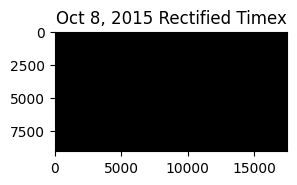

In [51]:
# Display our rectified frame
fig, axs = plt.subplots(1, figsize = (3,7))
axs.xaxis.set_visible(True)
axs.yaxis.set_visible(True)
axs.imshow(rect_frame.astype(np.uint8), 
        cmap="gray",
        vmin=0,
        vmax=255
    )
plt.title('Oct 8, 2015 Rectified Timex')
plt.show()

In [ ]:
-165.5362565997144 + 180

14.463743400285608

In [ ]:
A = np.unique(rect_frame)

In [ ]:
A

array([0], dtype=uint8)